In [ ]:
import stanza    
stanza.download('en') # download English model
nlp = stanza.Pipeline('en') # initialize English neural pipeline

In [1]:
import pandas as pd

# Importing the dataset
#dataset = pd.read_csv('../datasets/2018-EI-oc-En-fear-dev.txt', sep="\t", header=None, skiprows=1)


li = []
all_files= {'../datasets/2018-EI-oc-En-joy-dev.txt', '/home/joana/feup/iart/el-oc-tweets/datasets/EI-oc-En-joy-train.txt'}

for filename in all_files:
    df = pd.read_csv(filename, sep="\t", header=None, skiprows=1)
    li.append(df)

dataset = pd.concat(li, axis=0, ignore_index=True)

dataset.columns = ['date', 'text', 'emotion', 'level']
dataset= dataset.sample(frac=1)


In [ ]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import emoji
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 

corpus = []
ps = PorterStemmer()

for index, row in dataset.iterrows():
    tweet = row['text']

    #handle users
    tweet = re.sub('@.*', '@user', tweet) 

    
    
    tweet = tweet.lower().split()
    #tweet = nltk.word_tokenize(tweet)

    # stemming and stop word removal
    tweet = ' '.join([lemmatizer.lemmatize(w) for w in tweet if not w in set(stopwords.words('english'))])
    

    #tweet = nlp(tweet) # run annotation over a sentence
    
    
    #emojis
    tweet = emoji.demojize(tweet)
    
    corpus.append(tweet)

print(corpus)


In [2]:
from bert_embedding import BertEmbedding
import re
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import mxnet as mx


corpus = []

for index, row in dataset.iterrows():
    tweet = row['text']
    corpus.append(tweet)

bert = BertEmbedding(model='bert_24_1024_16', dataset_name='book_corpus_wiki_en_cased')
results = bert(corpus)
print(results)

 0.5032102 ], dtype=float32), array([ 1.5125241 ,  0.5466425 ,  0.24614906, ...,  0.16061874,
       -0.62531894,  0.48654366], dtype=float32), array([ 0.05016018,  0.04213976, -0.2688147 , ...,  0.12385698,
       -0.10498358,  0.2278524 ], dtype=float32), array([ 0.01417787,  0.31488854, -0.05968828, ..., -0.05511012,
       -0.23894192,  0.07181839], dtype=float32), array([ 0.3018583 ,  0.44832143,  0.47027078, ..., -0.02356464,
        0.08896874,  0.19115917], dtype=float32), array([-0.09701537,  0.51479465, -0.10980189, ...,  0.10071324,
       -0.3911328 ,  0.08285965], dtype=float32), array([-0.06366452,  0.29792145,  0.01229717, ...,  0.0973004 ,
       -0.14974457,  0.03893219], dtype=float32), array([-0.07169077,  0.49458313, -0.17975885, ..., -0.06808751,
       -0.14392821,  0.14833246], dtype=float32), array([-0.07655388,  0.90805763,  0.21604571, ..., -0.04002497,
        0.13028866,  0.18789336], dtype=float32)]), (['@', 'HasegawaSona', 'Big', ',', 'toothy', 'smile', 'a

In [3]:
import numpy as np
averaged = []
for sent in results:
    averaged.append(np.mean(sent[1], axis = 0, dtype=np.float64))

corpus=averaged
X=np.array(corpus)

In [ ]:
#TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer=TfidfVectorizer(use_idf=True)
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(corpus)

print(tfidf_vectorizer_vectors)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np


vectorizer = CountVectorizer(max_features = 1500)
#X = vectorizer.fit_transform(corpus).toarray()
#X = tfidf_vectorizer_vectors.toarray()
y = []
for index, row in dataset.iterrows():
    y.append(int(row['level'][0]))
    '''
    if(int(row['level'][0])==3):
        y.append(1) 
    elif(int(row['level'][0])>0):
        y.append(1) 
    else:
        y.append(0)
    '''
    
    
y = np.array(y)
#print(vectorizer.get_feature_names())
#print(type(X[0]), y.shape)

In [ ]:
'''
from nltk.featstruct import FeatStruct

X = []
i=0

for index, row in dataset.iterrows():
    element= []
    element.append(tfidf_vectorizer_vectors[i].toarray())
    element.append(np.array([0 if i !=len(row['text']) else 1 for i in range(500)]))
    element=np.array(element)
    element=element.flatten()
    X.append(element)
    i+=1
    fs1 = FeatStruct(tdidf=tfidf_vectorizer_vectors[i], size=[0 if i !=len(row['text']) else 1 for i in range(500)])
    X.append(fs1)
X=np.array(X)
print(X.shape)
'''

In [54]:
# Split dataset into training and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1524, 1024) (1524,)
(382, 1024) (382,)


In [ ]:
# Naive Bayes

from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

classifier = GaussianNB()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
print('Recall: ', recall_score(y_test, y_pred, average='weighted'))
print('F1: ', f1_score(y_test, y_pred, average='weighted'))

In [ ]:
# SVM

from sklearn.svm import SVC

classifier = SVC()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
print('Recall: ', recall_score(y_test, y_pred, average='weighted'))
print('F1: ', f1_score(y_test, y_pred, average='weighted'))

In [ ]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
print('Recall: ', recall_score(y_test, y_pred, average='weighted'))
print('F1: ', f1_score(y_test, y_pred, average='weighted'))

In [ ]:
# SGDC classifier

from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
print('Recall: ', recall_score(y_test, y_pred, average='weighted'))
print('F1: ', f1_score(y_test, y_pred, average='weighted'))

In [ ]:
from sklearn.neural_network import MLPClassifier

classifier = MLPClassifier(random_state=1, max_iter=300)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
print('Recall: ', recall_score(y_test, y_pred, average='weighted'))
print('F1: ', f1_score(y_test, y_pred, average='weighted'))

In [ ]:
# Perceptron
from sklearn.linear_model import Perceptron

classifier = Perceptron() 
classifier.fit(X_train, y_train) 
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred)) 
print('Accuracy: ', accuracy_score(y_test, y_pred)) 
print('Precision: ', precision_score(y_test, y_pred, average='weighted')) 
print('Recall: ', recall_score(y_test, y_pred, average='weighted')) 
print('F1: ', f1_score(y_test, y_pred, average='weighted'))

In [ ]:
# Decision Tree

from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
print('Recall: ', recall_score(y_test, y_pred, average='weighted'))
print('F1: ', f1_score(y_test, y_pred, average='weighted'))

In [ ]:
# Random Forest

from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred, average='weighted'))
print('Recall: ', recall_score(y_test, y_pred, average='weighted'))
print('F1: ', f1_score(y_test, y_pred, average='weighted'))

In [ ]:
# Simple test

import os
import numpy as np

tweet = input("Enter tweet: ")
tweet = re.sub('[^a-zA-Z]', ' ', rev).split()
tweet = ' '.join([ps.stem(w) for w in tweet])
X = vectorizer.transform([tweet]).toarray()

print(X.shape)
print(X)

print("Sentiment level: ", classifier.predict(X))

In [52]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

print(np.shape(X_test))
print(np.shape(y_test))
model = models.Sequential()
model.add(layers.Conv1D(32, 3, activation='relu',input_shape=(1524, 1024)))
model.add(layers.Dense(4))
'''
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=np.shape(X_test)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4))
'''
model.summary()

(382, 1, 1024)
(382,)
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, None, 32)          98336     
_________________________________________________________________
dense_5 (Dense)              (None, None, 4)           132       
Total params: 98,468
Trainable params: 98,468
Non-trainable params: 0
_________________________________________________________________


In [11]:
'''
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4))
model.summary()
'''

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)               

In [58]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

x_test_trans = np.expand_dims(X_train, axis=2)
print(np.shape(x_test_trans))
print(np.shape(y_train))
history = model.fit(x_test_trans, y_train, epochs=10, 
                    validation_data=(X_test, y_test))

(1524, 1024, 1)
(1524,)
Epoch 1/10


ValueError: in user code:

    /home/joana/envs/python37/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:571 train_function  *
        outputs = self.distribute_strategy.run(
    /home/joana/envs/python37/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/joana/envs/python37/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/joana/envs/python37/lib/python3.6/site-packages/tensorflow/python/distribute/distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/joana/envs/python37/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:531 train_step  **
        y_pred = self(x, training=True)
    /home/joana/envs/python37/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:886 __call__
        self.name)
    /home/joana/envs/python37/lib/python3.6/site-packages/tensorflow/python/keras/engine/input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential_26 is incompatible with the layer: expected axis -1 of input shape to have value 1024 but received input with shape [None, 1024, 1]


12/12 - 0s - loss: 6.9466 - accuracy: 0.0000e+00


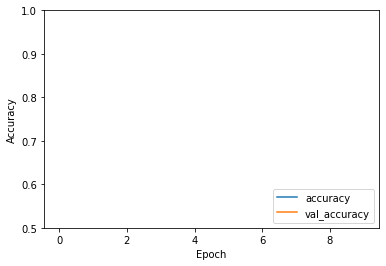

In [46]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)